In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from voting_mechanism_design.agents.pairwise_badgeholder import PairwiseBadgeholder, PairwiseBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.pairwise_binary import PairwiseBinary
from voting_mechanism_design.sim import RoundSimulation

import itertools
import numpy as np
import networkx as nx
import choix

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# round design variables

In [4]:
# create the badgeholders
n = 10
badgeholder_list = []
for ii in range(n):
    badgeholder_id = ii
    agent = PairwiseBadgeholder(
        badgeholder_id=badgeholder_id
    )
    badgeholder_list.append(agent)
badgeholders = PairwiseBadgeholderPopulation()
badgeholders.add_badgeholders(badgeholder_list)

In [5]:
# create projects
N = 20
projects = []
for ii in range(N):
    project_id = ii
    project = Project(
        project_id=project_id,
        true_impact=1,  # TODO: this should be a random variable
        owner_id=None,  # used for COI modeling
    )
    projects.append(project)
project_population = ProjectPopulation()
project_population.add_projects(projects)

In [6]:
fund_distribution_model = PairwiseBinary()

In [25]:
# create and run a simulation
simulation_obj = RoundSimulation(
    badgeholder_population=badgeholders,
    projects=project_population,
    funding_design=fund_distribution_model,
)
voting_view_ix = itertools.combinations(range(project_population.num_projects), 2)
#print(voting_view_ix)
voting_view = []
for ix1, ix2 in voting_view_ix:
    voting_view.append((project_population.get_project(ix1), project_population.get_project(ix2)))
#print(len(voting_view))
simulation_obj.run(cast_votes_kwargs={'view': voting_view})

190


In [8]:
all_votes = simulation_obj.badgeholder_population.get_all_votes()

# make a matrix of all the pairwise voting possibilities
project_list = simulation_obj.projects.projects
N = len(project_list)
project_vote_matrix = np.zeros((N, N))
project2ix = {p:ix for ix, p in enumerate(project_list)}
vote_data_list = []

# put the votes into the matrix for analysis
for v in all_votes:
    ix1 = project2ix[v.project1]
    ix2 = project2ix[v.project2]
    project_vote_matrix[ix1, ix2] += v.val1
    project_vote_matrix[ix2, ix1] += v.val2

    if v.val1 > v.val2:
        vote_data_list.append((ix1, ix2))
    elif v.val2 > v.val1:
        vote_data_list.append((ix2, ix1))
    else:
        # TODO: not sure if there is a tie, is that even possible??
        print('In Tie scenario!')
        pass

In [9]:
# estimate parameters of bradley terry model
params = choix.ilsr_pairwise(N, vote_data_list)
# create rank order of project ids
project_ix_worst_to_best = np.argsort(params)
project_ix_best_to_worst = project_ix_worst_to_best[::-1]

In [10]:
project_ix_best_to_worst

array([ 2, 10, 13, 16, 19,  3, 15, 14, 18,  5,  4,  0,  9, 12, 11,  6,  7,
        1, 17,  8], dtype=int64)

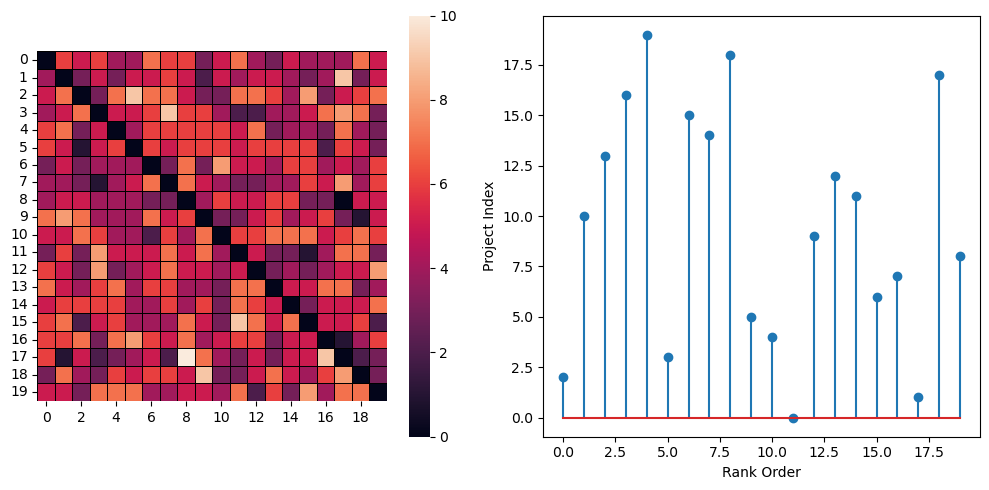

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(
    project_vote_matrix, 
    linewidths=0.5, 
    linecolor='black', 
    square=True,
    ax=ax[0]
)

ax[1].stem(project_ix_best_to_worst)
ax[1].set_ylabel('Project Index')
ax[1].set_xlabel('Rank Order')

plt.tight_layout()

In [12]:
## Links of interest:
#  1 - https://martiningram.github.io/mcmc-comparison/
#  2 - https://opisthokonta.net/?p=1589
